In [73]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import shutil
from skimage import io
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

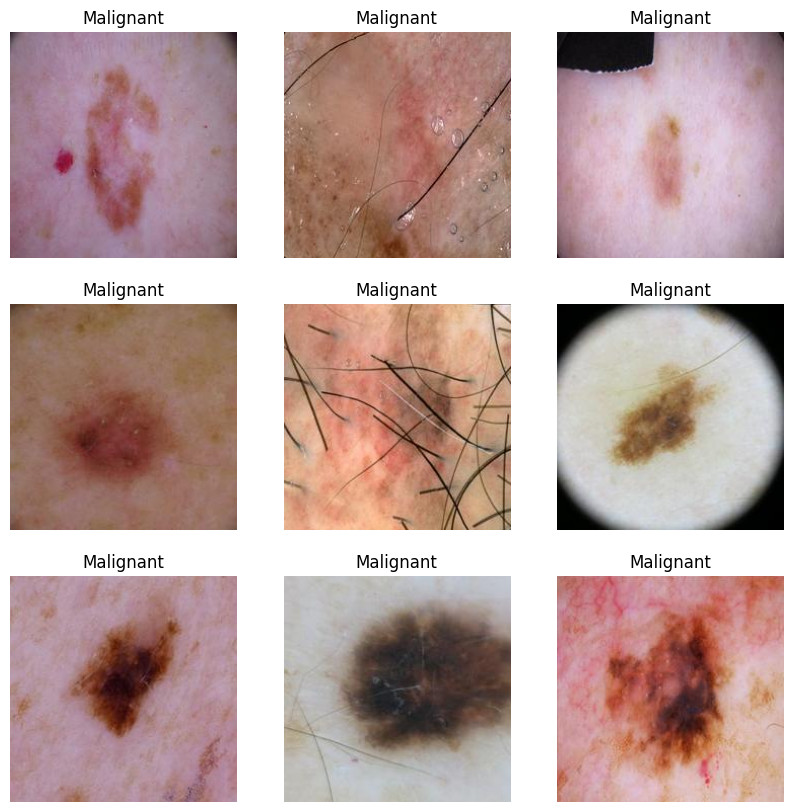

In [2]:
# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path)
                # Check if the image is valid (not None)
                if img is not None:
                    # Resize image to 224x224
                    img = cv2.resize(img, (224, 224))
                    # Convert BGR image to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Warning: Unable to load image '{img_path}'. Skipping...")
    return np.array(images), np.array(labels)

# Directory containing image data (benign and malignant subfolders)
train_dir = '../data/train'
test_dir = '../data/test'

# Load train and test images
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

# Display sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

In [3]:
# Directory containing image data (benign and malignant subfolders)
train_dir = '../data/train'

# Define the number of images to keep for each class
num_images_per_class = 5590

# Get the list of image filenames for each class
benign_images = os.listdir(os.path.join(train_dir, 'benign'))
malignant_images = os.listdir(os.path.join(train_dir, 'malignant'))

# Shuffle the list of benign images
random.shuffle(benign_images)

# Select a subset of benign images to keep
benign_images_to_keep = benign_images[:num_images_per_class]

# Delete the extra benign images
for filename in benign_images:
    if filename not in benign_images_to_keep:
        os.remove(os.path.join(train_dir, 'benign', filename))

# Print the number of images in each class after balancing
print(f"Number of benign images: {len(benign_images_to_keep)}")
print(f"Number of malignant images: {len(malignant_images)}")

Number of benign images: 5590
Number of malignant images: 5590


In [4]:
# Function to load and shuffle images from each class
def load_and_shuffle_images(directory, num_samples):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  # Check if it's a directory
            for filename in os.listdir(label_path):
                if not filename.startswith('.DS_Store'):  # Skip .DS_Store files
                    img_path = os.path.join(label_path, filename)
                    img = cv2.imread(img_path)
                    # Check if the image is valid (not None)
                    if img is not None:
                        # Resize image to 224x224
                        img = cv2.resize(img, (224, 224))
                        # Convert BGR image to RGB
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        images.append(img)
                        labels.append(label)
                    else:
                        print(f"Warning: Unable to load image '{img_path}'. Skipping...")
    # Shuffle images and labels together
    images, labels = shuffle(images, labels, random_state=42)
    return np.array(images), np.array(labels)

# Load and shuffle images from each class without sampling
X, y = load_and_shuffle_images(train_dir, num_samples=None)

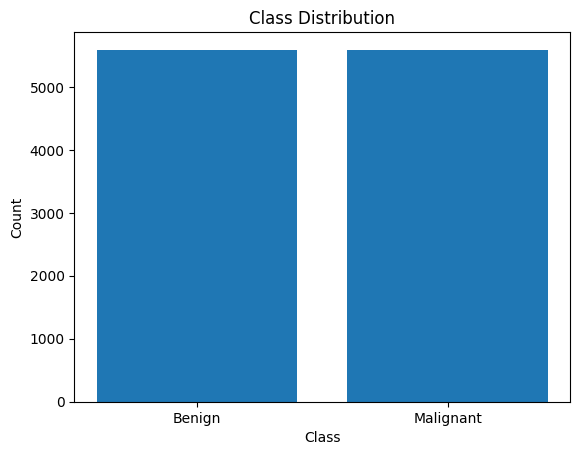

In [9]:
# 1. Class Distribution
class_distribution = np.unique(y, return_counts=True)
plt.bar(class_distribution[0], class_distribution[1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

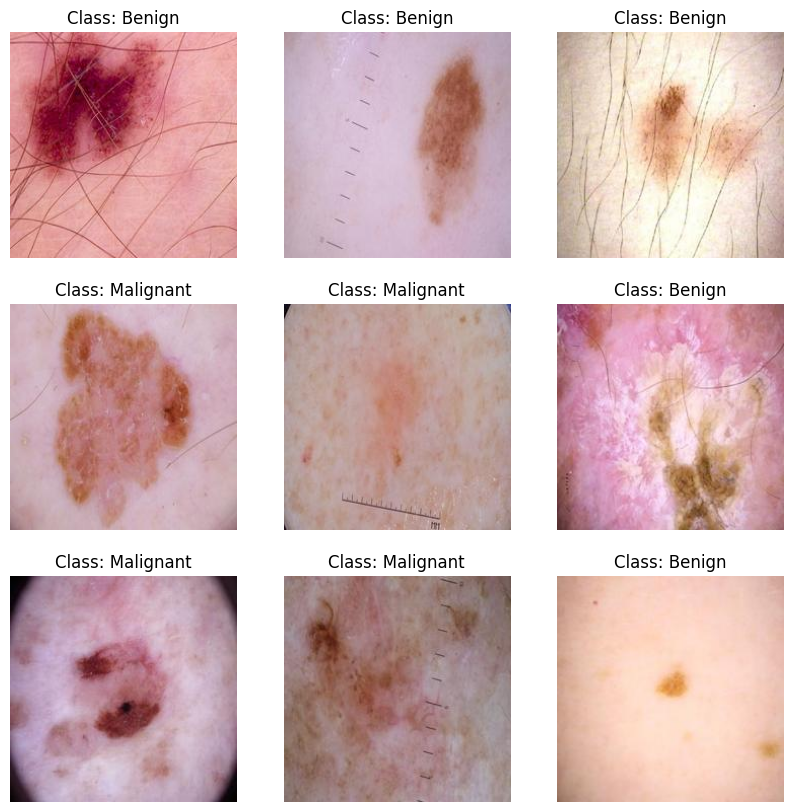

In [10]:
# 2. Image Visualization
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    plt.title(f'Class: {y[i]}')
    plt.axis('off')
plt.show()

In [11]:
# 3. Image Statistics
image_means = [np.mean(img) for img in X]
image_stds = [np.std(img) for img in X]
print(f'Mean pixel value: {np.mean(image_means):.2f}')
print(f'Standard deviation of pixel values: {np.mean(image_stds):.2f}')

Mean pixel value: 153.70
Standard deviation of pixel values: 43.92


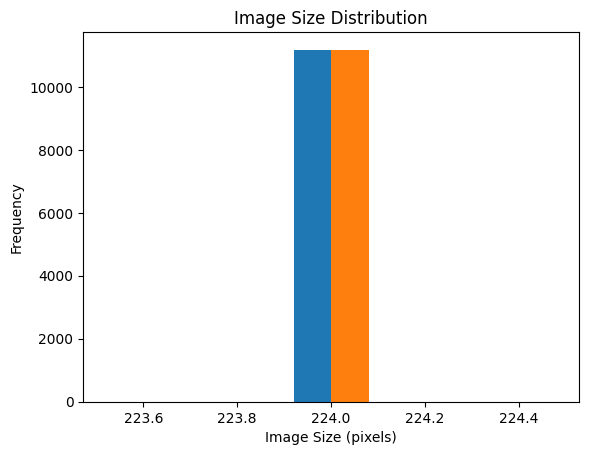

In [13]:
# 4. Image Size Distribution
image_sizes = np.array([img.shape[:2] for img in X])
plt.hist(image_sizes, bins=5)
plt.xlabel('Image Size (pixels)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.show()

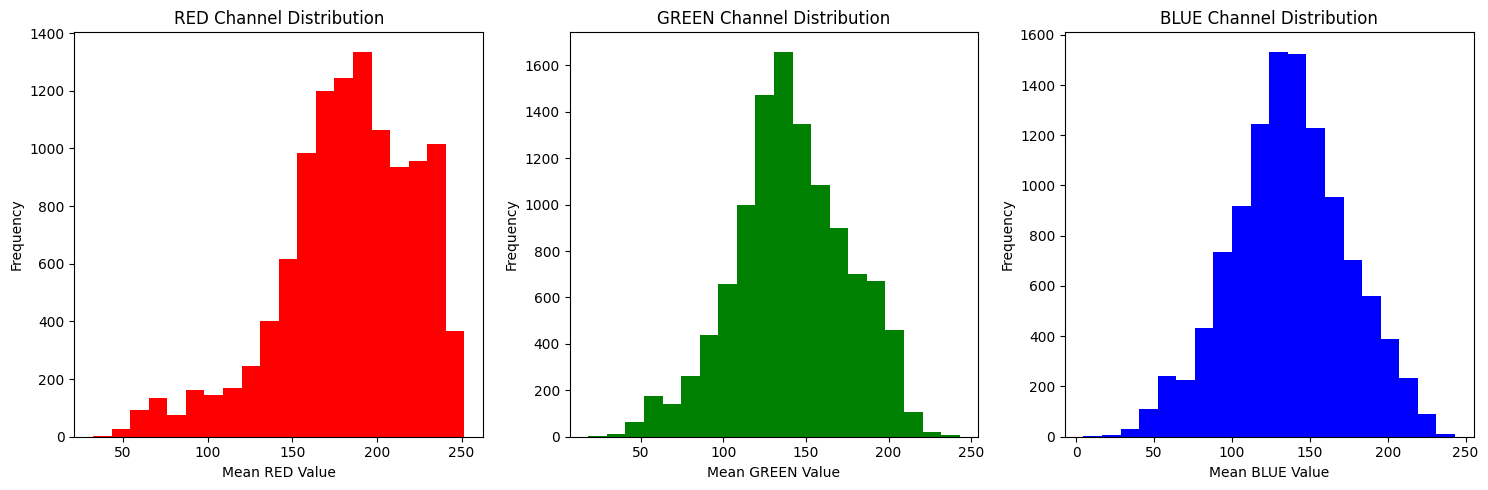

In [14]:
# 5. Color Distribution
plt.figure(figsize=(15, 5))
for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i + 1)
    color_values = [np.mean(img[:,:,i]) for img in X]
    plt.hist(color_values, bins=20, color=color)
    plt.xlabel(f'Mean {color.upper()} Value')
    plt.ylabel('Frequency')
    plt.title(f'{color.upper()} Channel Distribution')
plt.tight_layout()
plt.show()

In [5]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes of the datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (8943, 224, 224, 3) (8943,)
Validation set: (2236, 224, 224, 3) (2236,)


In [6]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels for training data
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform labels for validation data
y_val_encoded = label_encoder.transform(y_val)

# Print the unique classes and their encoded values
print("Classes:", label_encoder.classes_)
print("Encoded values:", np.unique(y_train_encoded))

Classes: ['Benign' 'Malignant']
Encoded values: [0 1]


In [7]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels for test data
y_test_encoded = label_encoder.fit_transform(y_test)

In [8]:
print("Data type of y_train_encoded:", y_train_encoded.dtype)
print("Data type of y_val_encoded:", y_val_encoded.dtype)

Data type of y_train_encoded: int64
Data type of y_val_encoded: int64


In [9]:
print("Data type of X_train:", X_train.dtype)
print("Data type of X_val:", X_val.dtype)

Data type of X_train: uint8
Data type of X_val: uint8


In [10]:
# Transform labels for test data
y_test_encoded = label_encoder.transform(y_test)
print("Classes:", label_encoder.classes_)
print("Encoded values:", np.unique(y_test_encoded))

Classes: ['Benign' 'Malignant']
Encoded values: [0 1]


In [11]:
print("Data type of X_train:", X_test.dtype)
print("Data type of X_val:", X_val.dtype)

Data type of X_train: uint8
Data type of X_val: uint8


In [12]:
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (8943, 224, 224, 3)
Validation set shape: (2236, 224, 224, 3)
Test set shape: (2000, 224, 224, 3)


In [13]:
# Flattening the images to 1D 787 pixels
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_flat = X_train_flat.astype('float32')
X_val_flat = X_val_flat.astype('float32')
X_test_flat = X_test_flat.astype('float32')

In [14]:
# Print the shape after flattening
print("\nShape after flattening:")
print("X_train_flat:", X_train_flat.shape)
print("X_val_flat:", X_val_flat.shape)
print("X_test_flat:", X_test_flat.shape)


Shape after flattening:
X_train_flat: (8943, 150528)
X_val_flat: (2236, 150528)
X_test_flat: (2000, 150528)


In [15]:
X_train_flat /= 255
X_val_flat /= 255
X_test_flat /= 255

In [16]:
# Define the number of classes
num_classes = len(np.unique(y_train))

In [17]:
# Perform one-hot encoding on labels
Y_train = to_categorical(y_train_encoded, num_classes)
Y_val = to_categorical(y_val_encoded, num_classes)
Y_test = to_categorical(y_test_encoded, num_classes)

In [20]:
# Define the input shape
input_shape = (150528,)

# Define the input layer
input_layer = Input(shape=input_shape)

# Define the rest of the model architecture
x = Dense(128, activation='relu')(input_layer)
x = Dense(128, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Define the optimizer with a custom learning rate
custom_optimizer = Adam(learning_rate=0.001)

# Compile the model with the custom optimizer
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_flat, Y_train, epochs=20, batch_size=32, validation_data=(X_val_flat, Y_val)) # validation_split=0.3

# Evaluate the model
loss, accuracy = model.evaluate(X_test_flat, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 125s 405ms/step - accuracy: 0.6481 - loss: 4.9525 - val_accuracy: 0.7737 - val_loss: 0.5210
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 104s 365ms/step - accuracy: 0.7571 - loss: 0.5579 - val_accuracy: 0.8108 - val_loss: 0.4309
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 93s 331ms/step - accuracy: 0.7764 - loss: 0.4882 - val_accuracy: 0.8292 - val_loss: 0.4303
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 90s 317ms/step - accuracy: 0.7532 - loss: 0.6185 - val_accuracy: 0.8059 - val_loss: 0.4160
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 155s 355ms/step - accuracy: 0.7969 - loss: 0.4409 - val_accuracy: 0.8305 - val_loss: 0.3902
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 91s 323ms/step - accuracy: 0.8048 - loss: 0.4299 - val_accuracy: 0.7858 - val_loss: 0.4590
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 91s 321ms/step - accuracy: 0.7926 - loss: 0.4617 - val_accuracy: 0.8184 - val_loss: 0.3827
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 92s 324ms/step - accuracy: 0.7999 - loss

In [22]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model # Train = Train2 + Val
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 3066s 11s/step - accuracy: 0.8065 - loss: 2.7460 - val_accuracy: 0.8658 - val_loss: 0.2994
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 3207s 11s/step - accuracy: 0.8990 - loss: 0.2432 - val_accuracy: 0.8842 - val_loss: 0.2838
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 3887s 14s/step - accuracy: 0.9329 - loss: 0.1543 - val_accuracy: 0.8913 - val_loss: 0.3394
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 3688s 13s/step - accuracy: 0.9507 - loss: 0.1164 - val_accuracy: 0.8851 - val_loss: 0.4004
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 3613s 13s/step - accuracy: 0.9570 - loss: 0.0972 - val_accuracy: 0.8945 - val_loss: 0.3850
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 3847s 14s/step - accuracy: 0.9709 - loss: 0.0812 - val_accuracy: 0.8945 - val_loss: 0.3717
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 4128s 15s/step - accuracy: 0.9764 - loss: 0.0589 - val_accuracy: 0.8931 - val_loss: 0.4615
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 3708s 13s/step - accuracy: 0.9771 - loss: 0

In [69]:
import keras 

def plot_metric(history: keras.callbacks.History, metric: str):
    '''
    Function to plot the training, and validation loss of a neural network during the training.

    Inputs:
    history: Keras callback with the historical progress

    metric: which metric of the training progress we want to plot

    Outputs:
    None
    '''
    train_metrics = history.history[metric] # Get the error metric for the TRAIN set
    val_metrics = history.history['val_'+metric] # Get the error metric for the VALIDATION set
    epochs = range(1, len(train_metrics) + 1) # range(1,6) -> 1,2,3,4,5
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.yscale('log')
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

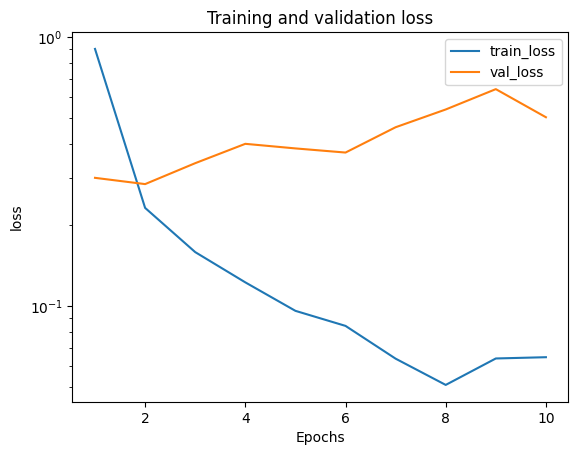

In [71]:
plot_metric(history, "loss")

In [72]:
#tf.keras.models.save_model(model, "../app/new_model.h5", save_format="h5")
#tf.keras.models.save_model(model, "../app/new_model.h5")
model.save("../app/new_model.keras")

In [61]:
'''
%%writefile ../app/app.py
import streamlit as st
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)
def load_model():
    model=tf.keras.models.load_model("../app/new_model.keras")
    return model
model=load_model()
st.write("""
         # Melanoma Classification
         """
        )

file = st.file_upload("Please upload your melanoma image", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict(image_data, model):
    size = (224, 224)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    img = np.asarray(image)
    img_reshape = img[np.newaxis,...]
    prediction = model.predict(img_reshape)
    return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    class_names=['benign', 'malignant']
    string="This mole most likely is: "+class_names[np.argmax(predictions)]
    st.success(string)
'''    

Overwriting ../app/app.py


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


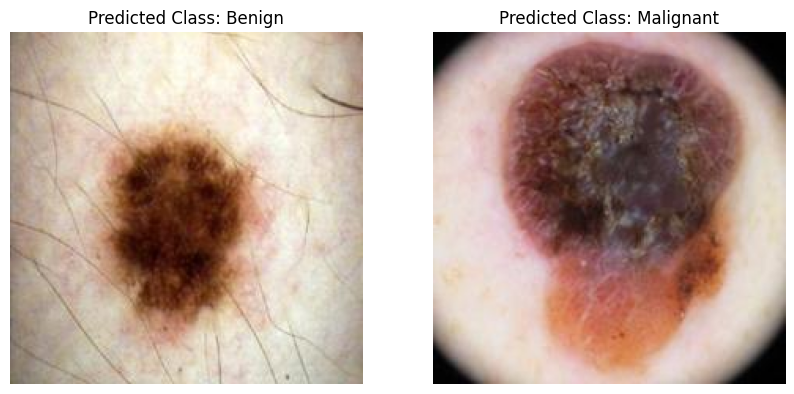

In [75]:
class_labels = ['Benign', 'Malignant']

# Define paths to benign and malignant images
benign_image_path = '../data/test/Benign/6307.jpg'
malignant_image_path = '../data/test/Malignant/5603.jpg'

# Load and preprocess the benign image
benign_img = image.load_img(benign_image_path, target_size=(224, 224))
benign_img_array = image.img_to_array(benign_img)
benign_img_array = np.expand_dims(benign_img_array, axis=0)

# Load and preprocess the malignant image
malignant_img = image.load_img(malignant_image_path, target_size=(224, 224))
malignant_img_array = image.img_to_array(malignant_img)
malignant_img_array = np.expand_dims(malignant_img_array, axis=0)

# Make predictions
benign_prediction = model.predict(benign_img_array)
malignant_prediction = model.predict(malignant_img_array)

# Get the predicted class for each image
benign_class = class_labels[np.argmax(benign_prediction)]
malignant_class = class_labels[np.argmax(malignant_prediction)]

# Display the images and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(benign_img)
plt.title(f'Predicted Class: {benign_class}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(malignant_img)
plt.title(f'Predicted Class: {malignant_class}')
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


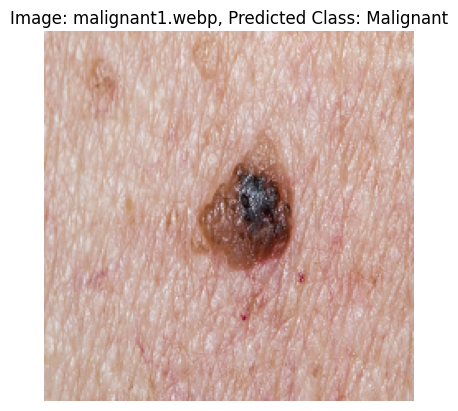

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


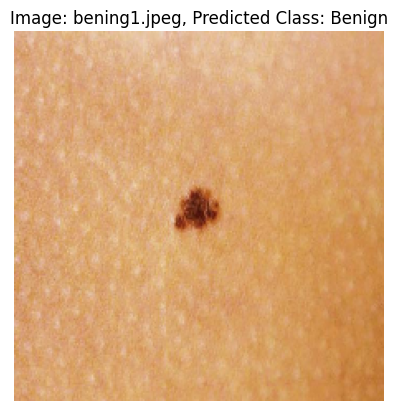

In [90]:
# Define class labels
class_labels = ['Benign', 'Malignant']

# Define path to the demo folder
demo_folder = '../model_demo'

# Get the list of image filenames in the demo folder
image_filenames = os.listdir(demo_folder)

# Iterate through each image in the demo folder
for image_filename in image_filenames:
    image_path = os.path.join(demo_folder, image_filename)
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Get the predicted class
    predicted_class = class_labels[np.argmax(prediction)]
    
    # Display the image, its filename, and the predicted class
    plt.imshow(img)
    plt.title(f'Image: {image_filename}, Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()